In [1]:
#!kaggle competitions download -c nlp-getting-started

In [1]:
import pandas as pd
import numpy as np
import os


import matplotlib.pyplot as plt

import emoji

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Embedding, LSTM,Dense, SpatialDropout1D, Dropout, SimpleRNN, Flatten, Conv1D, MaxPooling1D
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
import keras.backend as K 
from keras.callbacks import EarlyStopping

from keras.models import load_model


from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import WordPunctTokenizer  
from tensorflow.keras.preprocessing.text import text_to_word_sequence

from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *



Using TensorFlow backend.
/Users/reejungkim/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/reejungkim/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/reejungkim/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1

In [2]:
train = pd.read_csv("https://raw.githubusercontent.com/reejungkim/Natural-Language-Processing/master/nlp-getting-started/train.csv")
test = pd.read_csv("https://raw.githubusercontent.com/reejungkim/Natural-Language-Processing/master/nlp-getting-started/test.csv")


In [3]:
train.head(3)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1


In [4]:
test.head(3)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."


In [5]:
df = pd.concat([train, test], axis=0).reset_index(drop=True)

In [6]:
train.shape, test.shape, df.shape

((7613, 5), (3263, 4), (10876, 5))

In [7]:
df.tail()

,id,keyword,location,text,target
10871,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,NaN
10872,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,NaN
10873,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,NaN
10874,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,NaN
10875,10875,NaN,NaN,#CityofCalgary has activated its Municipal Eme...,NaN


In [12]:
not_disaster = df[df.target==0]
disaster = df[df.target==1]

In [13]:
disaster

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1.0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1.0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1.0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1.0
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1.0
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1.0
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1.0
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1.0


In [15]:
not_disaster.head()

,id,keyword,location,text,target
15,23,NaN,NaN,What's up man?,0.0
16,24,NaN,NaN,I love fruits,0.0
17,25,NaN,NaN,Summer is lovely,0.0
18,26,NaN,NaN,My car is so fast,0.0
19,28,NaN,NaN,What a goooooooaaaaaal!!!!!!,0.0


# EDA

In [14]:
for i in range(0, 10):
    print(i ,". ", disaster.text[i], "target: ",disaster.target[i] ) 

0 .  Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all target:  1.0
1 .  Forest fire near La Ronge Sask. Canada target:  1.0
2 .  All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected target:  1.0
3 .  13,000 people receive #wildfires evacuation orders in California  target:  1.0
4 .  Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school  target:  1.0
5 .  #RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires target:  1.0
6 .  #flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas target:  1.0
7 .  I'm on top of the hill and I can see a fire in the woods... target:  1.0
8 .  There's an emergency evacuation happening now in the building across the street target:  1.0
9 .  I'm afraid that the tornado is coming to our area... target:  1.0


In [11]:
disaster.loc[pd.notnull(disaster.keyword)].head(3)

,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1.0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1.0
37,55,ablaze,World Wide!!,INEC Office in Abia Set Ablaze - http://t.co/3...,1.0


In [12]:
disaster.loc[pd.notnull(disaster.location)].head(3)

,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1.0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1.0
37,55,ablaze,World Wide!!,INEC Office in Abia Set Ablaze - http://t.co/3...,1.0


# Feature engineering

In [16]:
def find_url(string): 
    text = re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',string)
    if text!=[]:
        return "".join(text)
    return None

In [17]:
df['url']= df['text'].apply(lambda x:find_url(x))
df.loc[pd.notnull(df.url)]

,id,keyword,location,text,target,url
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1.0,http://t.co/lHYXEOHY6C
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0.0,http://t.co/YAo1e0xngw
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1.0,http://t.co/2nndBGwyEi
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0.0,http://t.co/qqsmshaJ3N
37,55,ablaze,World Wide!!,INEC Office in Abia Set Ablaze - http://t.co/3...,1.0,http://t.co/3ImaomknnA
...,...,...,...,...,...,...
10865,10836,NaN,NaN,#Ebola #EbolaOutbreak Ebola Virus: Birmingham ...,NaN,http://t.co/tjpYlU9fOX
10866,10838,NaN,NaN,Malaysian PM confirms debris is from missing f...,NaN,http://t.co/pfAvW5QyqE
10868,10856,NaN,NaN,See the 16yr old PKK suicide bomber who detona...,NaN,http://t.co/hKuT5mSdtP
10873,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,NaN,http://t.co/UtbXLcBIuY


In [15]:
def extract_emojis(string):
    emoticon = "".join(c for c in string if c in emoji.UNICODE_EMOJI)
    if emoticon!="":
        return emoticon
    return None

extract_emojis("😘😳😍test")

'😘😳😍'

In [16]:
df['emoji']= df['text'].apply(lambda x: extract_emojis(x))

# process text

In [17]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)


In [18]:
df['text']=df['text'].apply(lambda x : remove_URL(x))

In [19]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

remove_emoji("Omg another Earthquake 😔😔")

'Omg another Earthquake '

In [20]:
df.text = df.text.apply(lambda x: remove_emoji(x))

In [21]:
stops = set(stopwords.words('english'))
from nltk.stem import WordNetLemmatizer
lm = WordNetLemmatizer()

In [22]:
def language_preprocessor(string):
    text =  re.sub('[^a-zA-Z]', ' ', string) #replace non-english with blank
    text = text.lower().split() #decapitalize texts
    text = [word for word in text if not word in stops] #remove stopword
    text = [lm.lemmatize(word) for word in text]  #lemmatization of texts
    return text #' '.join(text)  #text
    

In [23]:
df['text processed'] = df['text'].apply(lambda x: language_preprocessor(x)) 

In [24]:
df.head(3)

,id,keyword,location,text,target,url,emoji,text processed
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1.0,None,None,"[deed, reason, earthquake, may, allah, forgive..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.0,None,None,"[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1.0,None,None,"[resident, asked, shelter, place, notified, of..."


In [25]:
from collections import Counter

def common_words(df, col, n):
    counts = Counter([item for sublist in df[col] for item in sublist])
    common_words = pd.DataFrame(counts.most_common(n))
    common_words.columns =['Word','count']
    return common_words
    

In [26]:
disaster_common_words  = common_words(df.loc[df.target==1], 'text processed', 30)
disaster_common_words.head(5)

,Word,count
0,fire,268
1,news,151
2,amp,135
3,disaster,122
4,via,121


In [27]:
words = disaster_common_words.set_index("Word")['count'].to_dict()

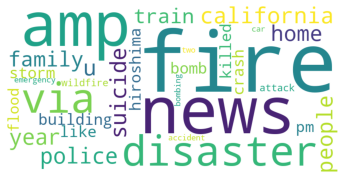

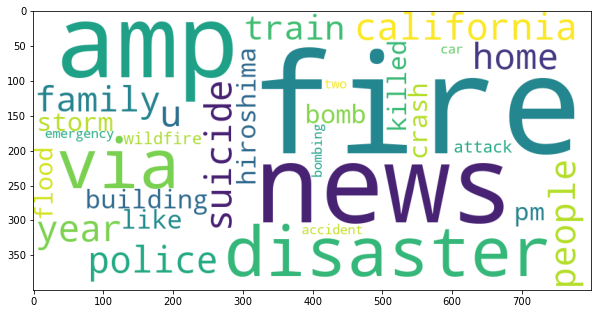

In [28]:
from wordcloud import WordCloud

wc = WordCloud(background_color='white',width=800, height=400)
wordcloud = wc.generate_from_frequencies(words)
plt.imshow(wordcloud)
plt.axis('off')
plt.figure( figsize=(10,10) )
plt.imshow(wordcloud)
#plt.show()


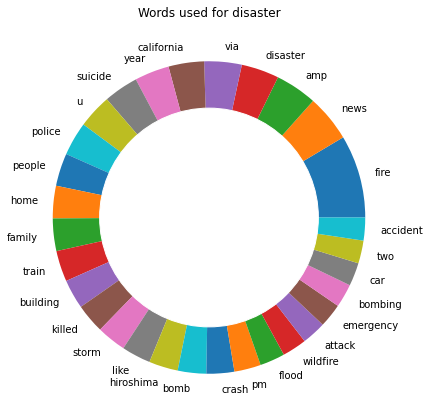

In [29]:
import matplotlib.pyplot as plt
#from palettable.colorbrewer.qualitative import Pastel1_7

plt.figure(figsize=(7,10))
my_circle=plt.Circle((0,0), 0.7, color='white')

plt.pie(disaster_common_words['count'], 
        labels=disaster_common_words.Word, startangle=-0) #,colors=Pastel1_7.hex_colors)

p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Words used for disaster')
plt.show()


# model application

In [30]:
train_data = df.loc[pd.notnull(df.target)]

In [31]:
df.head()

,id,keyword,location,text,target,url,emoji,text processed
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1.0,None,None,"[deed, reason, earthquake, may, allah, forgive..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.0,None,None,"[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1.0,None,None,"[resident, asked, shelter, place, notified, of..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1.0,None,None,"[people, receive, wildfire, evacuation, order,..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1.0,None,None,"[got, sent, photo, ruby, alaska, smoke, wildfi..."


In [32]:
train_data.tail(3)

,id,keyword,location,text,target,url,emoji,text processed
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii.,1.0,http://t.co/zDtoyd8EbJ,None,"[utc, km, volcano, hawaii]"
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1.0,None,None,"[police, investigating, e, bike, collided, car..."
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1.0,http://t.co/YmY4rSkQ3d,None,"[latest, home, razed, northern, california, wi..."


In [33]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['text processed'])
X_data = tokenizer.texts_to_sequences(train_data['text processed']) 

In [34]:
#X_data

In [35]:
word_to_index = tokenizer.word_index

In [36]:
#word_to_index

In [37]:
len(word_to_index)

14831

In [38]:
max(len(i) for i in X_data)

25

In [39]:
vocab_size = len(word_to_index) + 1

In [40]:
max_len = max(len(i) for i in X_data)

# padding

In [41]:
X_data = pad_sequences(X_data, maxlen = max_len)

In [42]:
X_data.shape

(7613, 25)

In [43]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data, train_data.target,
                                                    test_size=0.2, 
                                                    random_state=0)
 

In [44]:
np.array(X_train).shape, np.array(y_train).shape

((6090, 25), (6090,))

In [51]:
model = Sequential()
model.add(Embedding(vocab_size, 20)) 
model.add(SimpleRNN(30)) # RNN layers 
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',#'adagrad', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [54]:
history = model.fit(X_train, np.array(y_train), 
                    epochs=50, 
                    batch_size=1000, 
                    validation_split=0.2)

Train on 4872 samples, validate on 1218 samples
Epoch 1/50
4872/4872 [==============================] - 0s 61us/step - loss: 0.0683 - accuracy: 0.9813 - val_loss: 0.7242 - val_accuracy: 0.7176
Epoch 2/50
4872/4872 [==============================] - 0s 58us/step - loss: 0.0625 - accuracy: 0.9832 - val_loss: 0.7105 - val_accuracy: 0.7299
Epoch 3/50
4872/4872 [==============================] - 0s 58us/step - loss: 0.0598 - accuracy: 0.9834 - val_loss: 0.7174 - val_accuracy: 0.7348
Epoch 4/50
4872/4872 [==============================] - 0s 58us/step - loss: 0.0576 - accuracy: 0.9828 - val_loss: 0.7518 - val_accuracy: 0.7241
Epoch 5/50
4872/4872 [==============================] - 0s 58us/step - loss: 0.0548 - accuracy: 0.9807 - val_loss: 0.7655 - val_accuracy: 0.7258
Epoch 6/50
4872/4872 [==============================] - 0s 58us/step - loss: 0.0515 - accuracy: 0.9830 - val_loss: 0.7604 - val_accuracy: 0.7356
Epoch 7/50
4872/4872 [==============================] - 0s 59us/step - loss: 0.050

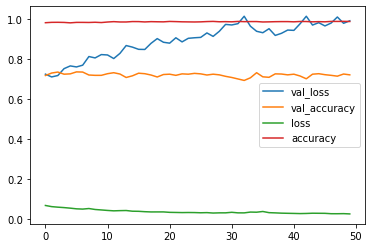

In [55]:
for name, value in history.history.items():
    plt.plot(value, label=name)
plt.legend()
plt.show()

In [56]:
model.evaluate(X_test, np.array(y_test))

1523/1523 [==============================] - 0s 124us/step


[0.906423680498971, 0.7406434416770935]

In [57]:
test_pred = model.predict(X_test)

In [58]:
test_pred

array([[0.16805074],
       [0.03475305],
       [0.9867835 ],
       ...,
       [0.98358005],
       [0.01960041],
       [0.9850589 ]], dtype=float32)

test_pred_target = test_pred.argmax(axis=-1)

In [59]:
test_pred_target = np.where( test_pred >.7, 1, 0)

In [60]:
test_pred_target

array([[0],
       [0],
       [1],
       ...,
       [1],
       [0],
       [1]])

In [61]:
y_test[:3]

311     0.0
4970    0.0
527     0.0
Name: target, dtype: float64

In [62]:
for pred, true, i, x  in zip(np.squeeze(test_pred_target), y_test, y_test.index, df['text processed'].index):
    if pred!= true:
        print(df.text[i])
        print("Text used: ", df['text processed'][i])
        print('Pred: {:.0f} - True: {:.0f}'.format(pred,true) , '\n')

1-6 TIX Calgary Flames vs COL Avalanche Preseason 9/29 Scotiabank Saddledome 
Text used:  ['tix', 'calgary', 'flame', 'v', 'col', 'avalanche', 'preseason', 'scotiabank', 'saddledome']
Pred: 1 - True: 0 

Despite the deluge of #FantasticFour notices our man O'Cuana is still buying tickets - because he's bloody-minded like that.
Text used:  ['despite', 'deluge', 'fantasticfour', 'notice', 'man', 'cuana', 'still', 'buying', 'ticket', 'bloody', 'minded', 'like']
Pred: 1 - True: 0 

Short of throwing them overboard himself I don't think any other leader could do much worse by #refugees than @TonyAbbottMHR worst pm ever!
Text used:  ['short', 'throwing', 'overboard', 'think', 'leader', 'could', 'much', 'worse', 'refugee', 'tonyabbottmhr', 'worst', 'pm', 'ever']
Pred: 0 - True: 1 

Im so anxious though because so many ppl will me watching me meet them and that makes me uncomfortable BUT I CANT LET THAT RUIN THE MOMENT
Text used:  ['im', 'anxious', 'though', 'many', 'ppl', 'watching', 'meet', 

In [63]:
 test_set = df.loc[df.target.isnull()]

In [64]:
test_set

,id,keyword,location,text,target,url,emoji,text processed
7613,0,NaN,NaN,Just happened a terrible car crash,NaN,None,None,"[happened, terrible, car, crash]"
7614,2,NaN,NaN,"Heard about #earthquake is different cities, s...",NaN,None,None,"[heard, earthquake, different, city, stay, saf..."
7615,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",NaN,None,None,"[forest, fire, spot, pond, goose, fleeing, acr..."
7616,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,NaN,None,None,"[apocalypse, lighting, spokane, wildfire]"
7617,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,NaN,None,None,"[typhoon, soudelor, kill, china, taiwan]"
...,...,...,...,...,...,...,...,...
10871,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,NaN,None,None,"[earthquake, safety, los, angeles, safety, fas..."
10872,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,NaN,None,None,"[storm, ri, worse, last, hurricane, city, amp,..."
10873,10868,NaN,NaN,Green Line derailment in Chicago,NaN,http://t.co/UtbXLcBIuY,None,"[green, line, derailment, chicago]"
10874,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO),NaN,http://t.co/3X6RBQJHn3,None,"[meg, issue, hazardous, weather, outlook, hwo]"


In [65]:
def returnBinaryPrediction(p):
    if p <= .5:
        return 0
    else:
        return 1

In [78]:
def returnPrediction(test_set):
    
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(test_set['text processed'])
    X_data = tokenizer.texts_to_sequences(test_set['text processed']) 
    
    max_len = max(len(i) for i in X_data)
    
    X_data = pad_sequences(X_data, maxlen = max_len)
    
    prediction_p= model.predict(X_data)
    #prediction = prediction_p.argmax(axis=-1)
    prediction = np.where( prediction_p >.7, 1, 0) #prediction_p.argmax(axis=-1)
    return prediction

np.where((returnPrediction(test_set) >.7), 1, 0)

In [79]:
returnPrediction(test_set)

array([[1],
       [1],
       [0],
       ...,
       [0],
       [1],
       [1]])

In [80]:
len(returnPrediction(test_set))

3263

In [81]:
submit_result = pd.DataFrame(returnPrediction(test_set))

In [82]:
submit_id = pd.DataFrame(test_set.id)

In [83]:
submit_result

,0
0,1
1,1
2,0
3,0
4,1
...,...
3258,1
3259,1
3260,0
3261,1


In [84]:
submit_id.reset_index(drop=True, inplace=True)
submit_id

,id
0,0
1,2
2,3
3,9
4,11
...,...
3258,10861
3259,10865
3260,10868
3261,10874


In [85]:
submission = pd.concat([submit_id, submit_result], axis=1)

In [86]:
submission.columns

Index(['id', 0], dtype='object')

In [87]:
submission = submission.rename({0:"target"}, axis='columns') 
submission

,id,target
0,0,1
1,2,1
2,3,0
3,9,0
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,0
3261,10874,1


In [88]:
submission.to_csv('to_submit.csv', index=False)

In [89]:
submission.target.unique()

array([1, 0])